In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import seaborn

In [3]:
import datetime
from dateutil import parser

In [4]:
from pymongo import MongoClient

In [61]:
client = MongoClient()
db = client['rf_test']
col_entries = db['entries']
col_inst = db['inst']
col_inds = db['inds']
col_nouns = db['nouns']

### Plotting distribution over time

In [16]:
def list_indicators():
    d = col_inst.distinct("attributes.indicator")
    return [x for x in d]

def compute_time_series(indicator):
    """
    Convert the time stamp in the db into something that we can plot.
    """
    c = col_inst.find({"attributes.indicator": indicator})
    c = [x for x in c]
    c_dates = [parser.parse(a['start']) for a in c]
    c_dates = [mdates.date2num(b) for b in c_dates]
    return c_dates

In [19]:
def plot_dist(s_dates):
    """
    Plot a time series.
    """
    locator = mdates.AutoDateLocator()
    locator.intervald[mdates.DAILY] = [2]
    formatter = mdates.AutoDateFormatter(locator)
    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter=formatter)
    ax = seaborn.distplot(s_dates, ax=ax)
    seaborn.plt.show()
    return (fig, ax)

In [7]:
inds = list_indicators()

In [14]:
stux_dates = compute_time_series("Stuxnet")

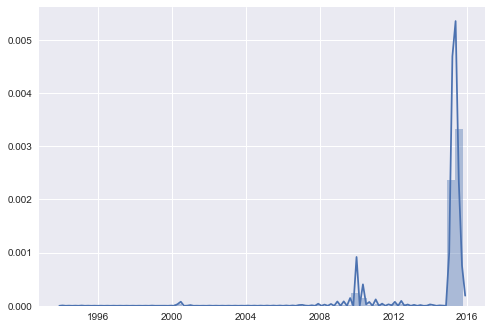

In [21]:
try:
    plot_dist(stux_dates)
except:
    print("something's wrong")

In [22]:
superfish_dates = compute_time_series("Superfish")

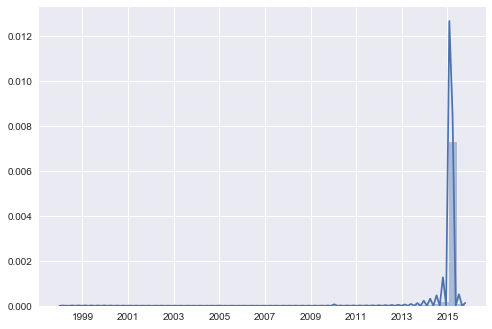

In [23]:
try:
    plot_dist(superfish_dates)
except:
    print("something's wrong")

### Ranking 

In [31]:
def analyse_inds(indicators):
    i = 0
    for ind in indicators:
        dates = compute_time_series(ind)
        size = len(dates)
        data = {
            "_id": ind,
            "dates": dates,
            "size": size,
        }
        col_inds.insert_one(data)
        i += 1
        print("{}/{} Inserted {}".format(i,len(indicators),ind))

In [32]:
# Test with the first thirty indicators
analyse_inds(inds[20:30])

1/10 Inserted XcodeGhost
2/10 Inserted Duqu 2.0 hits Kaspersky , Nominet
3/10 Inserted 0day
4/10 Inserted malware
5/10 Inserted Yispecter
6/10 Inserted Stuxnet attack was launched successfully on Iran
7/10 Inserted FLAME
8/10 Inserted Bladabindi
9/10 Inserted Nuclear exploit kit
10/10 Inserted Blackenergy attacks on industrial control systems


In [116]:
def print_sorted(col, attr):
    a = col.find({}).sort(attr, -1)
    xs = []
    ys = []
    for ind in a:
        print("{} | {}".format(ind[attr], ind['_id']))
        xs.append(ind['_id'])
        ys.append(ind[attr])
    return (xs, ys)
def plot_ranking(data, limit = 10):
    """
        Bar plot the data, but have some limit, 
        since if we plot all of it, we can't read the x-axis' label
    """
    xs, ys = data
    seaborn.barplot(x = xs[:limit], y = ys[:limit])
    seaborn.plt.show()

12326 | Stuxnet
10929 | malware
7511 | Superfish
5707 | XcodeGhost
5526 | Trojan
3880 | Malware
1714 | Regin malware
1371 | Stuxnet - style campaign against North Korea
1232 | Yispecter
1138 | Angler Exploit Kit
768 | Viper attack
674 | hackers steal over 250,000 Apple
395 | US launched failed Stuxnet attack
204 | zig zag
169 | 0day
134 | Blackenergy attacks on industrial control systems
103 | Stuxnet against North Korea
94 | Nuclear exploit kit
84 | Emotet Banking Malware targets German
80 | Cryptowall
77 | Ghost Push' Malware infects 600k Android
73 | FLAME
73 | Bladabindi
6 | HTran
3 | кибератака http
2 | malware coined as " SYNful Knock" was discovered on Cisco
2 | Neutrino EK on 46.108.156.181
2 | Stuxnet attack was launched successfully on Iran
1 | Deathring ] Chinese Malware found pre - installed on several smartphones
1 | Duqu 2.0 hits Kaspersky , Nominet


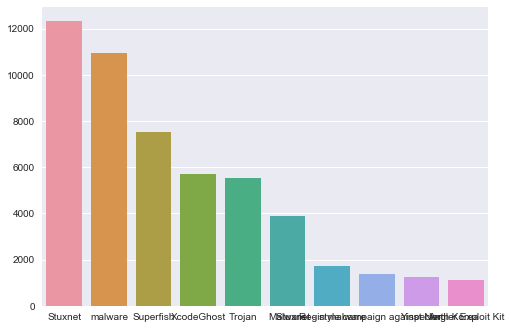

In [117]:
plot_ranking(print_sorted(col_inds, "size"))

### A little word association

In [47]:
from nltk.tag import pos_tag

In [48]:
def find_nouns(sentence):
    words = sentence.split()
    tagged = pos_tag(words)
    return [w for w, t in tagged if t == 'NNP']

In [54]:
# Test:
find_nouns("I love McDonald, and also the hammer. Superfish is a good friend of Stuxnet")

['McDonald,', 'Superfish', 'Stuxnet']

In [109]:
# We go through the sentences in the dataset. 
# Using the indicator as the id, we find all of the words associated with it.
# Let's test on a small one, try "Regin malware"

def other_nouns(indicator):
    c = col_inst.find({"attributes.indicator": indicator})
    c = [a for a in c] # I think this could be optimize for memory usage
    noun_count = {}
    for item in c:
        s = item['item_fragment']
        nouns = find_nouns(s)
        for noun in nouns:
            try:
                noun_count[noun].append(item['id'])
            except KeyError:
                noun_count[noun] = [item['id']]
        #print("Added {}".format(s))
    r = {}
    for k, v in noun_count.items():
        r[k] = {
            "ids": v,
            "size": len(v),
        }
    noun_count = sanitize(r)
    col_nouns.insert_one({"_id": indicator, "associated_nouns": noun_count})
    return noun_count

def sanitize(d):
    r = {}
    for k, v in d.items():
        try:
            k.index(".")
        except ValueError:
            r[k] = v
        else:
            nk = k.replace(".", "")
            r[nk] = v
    return r

def associated_nouns(indicator):
    noun_dict = other_nouns(indicator)
    ranking = sorted([(k, v['size']) for k, v in regin.items()], key= lambda x: x[1])[::-1]
    for n,s in ranking:
        print("{} | {}".format(s, n))
    return ranking
        
def plot_associated_nouns(ranks):
    """
        Bar plot for the ranking table of nouns. 
        However, this is worthless since all of the label runs together if you tried with the whole table.
    """
    seaborn.barplot(x = [i[0] for i in ranks], y = [i[1] for i in ranks])
    seaborn.plt.show()

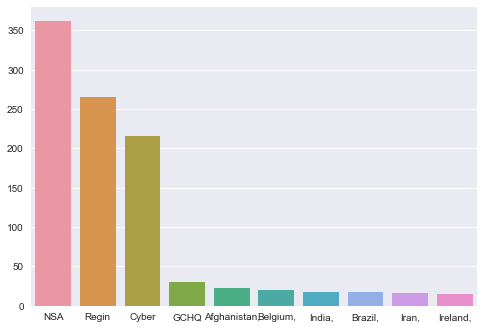

In [110]:
# Much better if you only look at a limited set
plot_associated_nouns(ranking[:10])